In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
from tqdm import tqdm
import pickle

import hexbin_functions as hexfunc

/nethome/6525954/.conda/envs/nemo-ensemble/lib/python3.12/site-packages/h3/unstable/__init__.py:4: UserWarning: Modules under `h3.unstable` are experimental, and may change at any time.
  warnings.warn(


In [2]:
# load the hexbin grid 

with open('../data/hexgrid_no_coast.pkl', 'rb') as f:
    hexbin_grid = pickle.load(f)
    
hexbin_grid = hexfunc.hexGrid(hexbin_grid, h3_res=3)

In [3]:
hexbin_grid.info()

Number of hexagons in the region with grid resolution 3: 4644
Levels: 1
Total number of bins: 4644


In [4]:
hexbin_grid.hexint

array([591788287992004607, 591470666570530815, 592877491698270207, ...,
       592036227864068095, 590135515857027071, 590407713704378367])

In [5]:
def entropy(Pdf):
    # Pdf = Pdf / np.nansum(Pdf)  # Normalize Pdf to sum to 1, ignoring NaNs
    # Replace zeros with a very small number to avoid log(0)
    Pdf_safe = np.where(Pdf > 0, Pdf, np.finfo(float).eps)
    return -np.nansum(Pdf_safe * np.log(Pdf_safe))

In [6]:
location = 'Cape_Hatteras'
member = 50 # memeber
std = 0.2 # Standard deviation od initial dispersion

file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/{location}/std_{std*100:03.0f}/{location}_std{std*100:03.0f}_m{member:03d}.zarr"
pset = xr.open_zarr(file_path)

In [7]:
file_path

'/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/Cape_Hatteras/std_020/Cape_Hatteras_std020_m050.zarr'

In [48]:
subgroups = {}

max_gap = 15
timesteps = np.linspace(1, 745, 745, dtype=int)
max_releases = timesteps[0::max_gap].shape[0]

set = np.linspace(0, 99, 100, dtype=int)

for gap in range(0, max_gap):
    
    if gap == 0:
        indexes = pset.trajectory.values
    else:
        set_start = timesteps[0::gap][:max_releases]*100
        indexes = []
    
        for j in set_start:
            indexes = indexes + list(j+set)
    
    subgroups[gap] = np.array(indexes)

In [49]:
# Load the hexbin_grid for the domain

# load the hexbin grid 

with open('../data/hexgrid_no_coast.pkl', 'rb') as f:
    hexbin_grid = pickle.load(f)
    
hexbin_grid = hexfunc.hexGrid(hexbin_grid, h3_res=3)

In [9]:
obs_length = len(pset.obs)
n_hex = hexbin_grid.n_hex
probability_sets = {}
entropy_sets = {}

# set zero is the full set of particles
# from set 1 to 14 is the subsets of particles released at different times

for t_gap in tqdm(subgroups.keys()):
    
    sub_pset = pset.isel(trajectory=subgroups[t_gap])
    
    probability_subset = np.zeros((n_hex, obs_length))
    entropy_subset = np.zeros(obs_length)

    lons, lats = sub_pset['lon'][:, :].values, sub_pset['lat'][:, :].values

    for t in range(obs_length):
        probability_subset[:, t] = hexbin_grid.count_2d(lons[:, t], lats[:, t], normalize=True)
        entropy_subset[t] = entropy(probability_subset[:, t])
    
    probability_sets[t_gap] = probability_subset
    entropy_sets[t_gap] = entropy_subset

  0%|          | 0/15 [00:43<?, ?it/s]


KeyboardInterrupt: 

In [50]:
def calculate_probability_and_entropy(pset, hexbin_grid, subgroups, entropy_function):
    """
    Calculates probability and entropy for particle sets over a hexagonal grid.

    Parameters
    ----------
    pset : xarray.Dataset
        Particle dataset containing longitude and latitude variables.
    hexbin_grid : hexGrid object
        An object representing the hexagonal grid, with a method count_2d to count particles within each hexbin.
    subgroups : dict
        Dictionary mapping t_gap values to indices of particles released at different times.
    entropy_function : function
        Function to calculate entropy given a probability distribution.

    Returns
    -------
    probability_sets : dict
        Dictionary of probability arrays for each t_gap, with dimensions (n_hex, obs_length).
    entropy_sets : dict
        Dictionary of entropy values for each t_gap, with dimension (obs_length).
    """
    obs_length = len(pset.obs)
    n_hex = hexbin_grid.n_hex
    probability_sets = {}
    entropy_sets = {}

    for t_gap in tqdm(subgroups.keys()):
        if t_gap == 0:
            sub_pset = pset
        else:
            sub_pset = pset.isel(trajectory=subgroups[t_gap])

        probability_subset = np.zeros((n_hex, obs_length))
        entropy_subset = np.zeros(obs_length)

        lons, lats = sub_pset['lon'][:, :].values, sub_pset['lat'][:, :].values

        for t in range(obs_length):
            probability_subset[:, t] = hexbin_grid.count_2d(lons[:, t], lats[:, t], normalize=True)
            entropy_subset[t] = entropy_function(probability_subset[:, t])

        probability_sets[t_gap] = probability_subset
        entropy_sets[t_gap] = entropy_subset

    return probability_sets, entropy_sets

In [51]:
def create_dataframe(probability_sets, entropy_sets, hexints):
    """
    Creates xarray Dataframe containing the probability and entropy data.

    Parameters
    ----------
    probability_sets : dict
        Dictionary containing probability data arrays for each delta_t.
    entropy_sets : dict
        Dictionary containing entropy data arrays for each delta_t.
    hexints : list
        List of hexagonal bin indices.
    obs_length : int
        The length of the observation period.
    filename : str
        The filename to save the NetCDF file.
    
    Returns
    -------
    ds : xarray.Dataset
        The dataset containing the probability and entropy data.
    """

    ds = xr.Dataset(
        {
            'probability': xr.DataArray(
                np.array([probability_sets[i] for i in range(0, 15)]),
                dims=['delta_t', 'hexint', 'time'],
                coords={
                    'delta_t': range(0, 15),
                    'hexint': hexints,
                    'time': range(probability_sets[0].shape[1])
                },
                attrs={
                    'description': 'Probability of occurrence for each time step, hexagonal bin, and observation time',
                    'units': 'probability'
                }
            ),
            'entropy': xr.DataArray(
                np.array([entropy_sets[i] for i in range(0, 15)]),
                dims=['delta_t', 'time'],
                coords={
                    'delta_t': range(0, 15),
                    'time': range(probability_sets[0].shape[1])
                },
                attrs={
                    'description': 'Entropy values for each time step and observation time',
                    'units': 'nats'
                }
            )
        }
    )
    
    return ds

In [58]:
obs_length

1400

In [52]:
location = 'Cape_Hatteras'
member = 1 # memeber
std = 0.01 # Standard deviation od initial dispersion

for member in tqdm([1]): #[1, 2, 47, 48, 49, 50]
    print(member)
    path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/{location}/std_{std*100:03.0f}/{location}_std{std*100:03.0f}_m{member:03d}.zarr"

    pset = xr.open_zarr(path)
    P_m, H_m = calculate_probability_and_entropy(pset, hexbin_grid, subgroups, entropy)
    DF_m = create_dataframe(P_m, H_m, hexbin_grid.hexint)
    # DF_m.to_netcdf(f"../data/analysis/probability_distribution/{location}/P_std{std*100:03.0f}_m{member:03d}.nc")

  0%|          | 0/1 [00:00<?, ?it/s]

1


100%|██████████| 1/1 [08:58<00:00, 538.04s/it]


In [62]:
P_m[0].shape[1]

1400

In [56]:
DF_m.to_zarr(f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}/P_std{std*100:03.0f}_m{member:03d}.nc")

In [64]:
xr.open_zarr(f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}/P_std{std*100:03.0f}_m{member:03d}")

<xarray.Dataset> Size: 780MB
Dimensions:      (delta_t: 15, time: 1400, hexint: 4644)
Coordinates:
  * delta_t      (delta_t) int64 120B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * hexint       (hexint) int64 37kB 590442348320653311 ... 591175928734810111
  * time         (time) int64 11kB 0 1 2 3 4 5 ... 1394 1395 1396 1397 1398 1399
Data variables:
    entropy      (delta_t, time) float64 168kB dask.array<chunksize=(15, 1400), meta=np.ndarray>
    probability  (delta_t, hexint, time) float64 780MB dask.array<chunksize=(2, 581, 175), meta=np.ndarray>

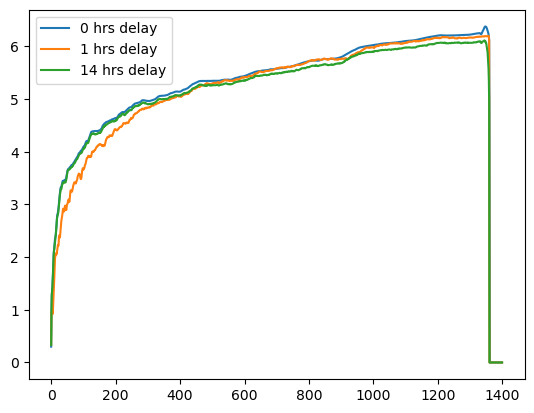

In [36]:
for delta_t in [0, 1, 14]:
    plt.plot(entropy_sets[delta_t], label=f'{delta_t} hrs delay')
    
plt.legend()

kfsdmmf

In [71]:
print(f"\U0001F914 Member: {member:03d},  std: {std:03.0f}")

🤔 Member: 001,  std: 000


In [65]:
std_ranges = np.linspace(1, 20, 20)/100

In [66]:
std_ranges

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ])

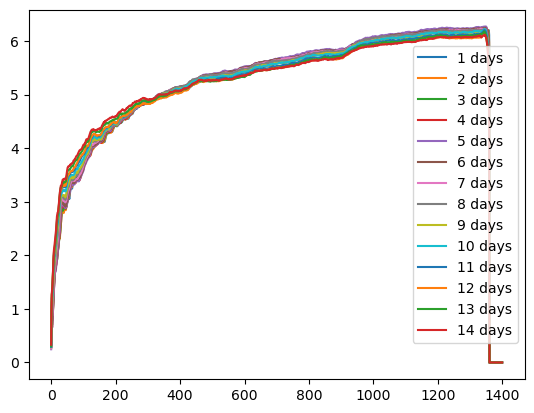

In [8]:
for delta_t in range(1, 15):
    plt.plot(entropy_sets[delta_t], label=f'{delta_t} days')
    
plt.legend()


A channel will always have an input and an output. A channel defines a set of conditional distributons. If you condition on an input the channel defines what the probability of the output is going to be. 

A channel is a set of conditional distributions.

Noisy channels is they're always going to have an input and an output and a channel defines a set of conditional distributions if you conditioned on an input the channel defines what the probability of the output is going to be.

The capacity of a channel $Q$ is defined and the input probability distribution $P_X$ that maximazes the mutual information $I(X|Y)$.